In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2024-08-16 23:47:06--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  25.2MB/s    in 3.3s    

2024-08-16 23:47:09 (24.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



# 라이브러리

In [ ]:
# 파이썬 표준 라이브러리
import gc
import random
import string
import re

# 파이썬 서드파티 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sentencepiece as spm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import ops

# 클래스

## 위치 임베딩

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length: int, input_dim: int, output_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens *= tf.math.sqrt(tf.cast(self.output_dim, tf.float32))
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
        })
        return config

## 디코더 레이어

In [ ]:
class DecoderLayer(layers.Layer):
    def __init__(self, embed_dim: int, dense_dim: int, num_heads: int, dropout_rate: float=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.dense_proj = keras.Sequential([
            layers.Dense(units=dense_dim, activation="relu"),
            layers.Dense(units=embed_dim),
            layers.Dropout(rate=dropout_rate)
        ])
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7) # 16비트 연산을 지원하지 않는 GPU의 경우 오류가 나므로 32비트 연산으로 바꾸기 위해 설정
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)
        self.dropout = layers.Dropout(rate=dropout_rate)

    def call(self, inputs, decoder_pad_mask, causal_mask):
        attention_output_1 = self.attention_1(
            inputs,
            inputs,
            attention_mask=decoder_pad_mask & causal_mask)
        attention_output_1 = self.dropout(attention_output_1)
        attention_output_1 = self.layernorm_1(layers.Add()([inputs, attention_output_1])) # inputs + attention_output_1는 mask 전파가 안됨
        proj_output = self.dense_proj(attention_output_1)
        return self.layernorm_2(layers.Add()([attention_output_1, proj_output])) # attention_output_2 + proj_output는 mask 전파가 안됨

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

## GPT

In [ ]:
class GPT(keras.Model):
    def __init__(self, *, num_layers, sequence_length, input_dim, embed_dim,
                 dense_dim, num_heads, dropout_rate):
        super().__init__()
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.pos_embedding = PositionalEmbedding(sequence_length=sequence_length,
                                                 input_dim=input_dim,
                                                output_dim=embed_dim,
                                                 name="Decoder_PositionalEmbedding")
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

        self.dec_layers = [
                            DecoderLayer(embed_dim=embed_dim, dense_dim=dense_dim,
                                         num_heads=num_heads, dropout_rate=dropout_rate)
                            for _ in range(num_layers)]

        self.final_layer = tf.keras.layers.Dense(units=input_dim)

    def call(self, inputs):
        decoder_pad_mask = tf.math.not_equal(inputs, 0)[:, tf.newaxis]
        decoder_sequence_length=tf.shape(inputs)[1]
        causal_mask = tf.linalg.band_part(tf.ones((decoder_sequence_length, decoder_sequence_length), tf.bool), -1, 0)

        # inputs -> Token-IDs Shape: (batch, decoder_sequence_length)
        inputs = self.pos_embedding(inputs)  # Shape: (batch_size, decoder_sequence_length, embed_dim)
        inputs = self.dropout(inputs)

        for i in range(self.num_layers):
            inputs  = self.dec_layers[i](inputs=inputs, decoder_pad_mask=decoder_pad_mask, causal_mask=causal_mask)

        logits = self.final_layer(inputs)  # Shape: (batch_size, decoder_sequence_length, target_vocab_size)

        try:
            # losses/metrics가 커지지 않게 keras_mask를 제거
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

## 1사이클 스케줄링

In [ ]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embed_dim, warmup_steps=4000):
        super().__init__()
        self.embed_dim = embed_dim
        self.embed_dim = tf.cast(self.embed_dim, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embed_dim) * tf.math.minimum(arg1, arg2)

## 텍스트 생성기

In [ ]:
class TextGenerator(tf.Module):
    # 데이터 전처리 함수
    @staticmethod
    def preprocess_text(text_: str, max_repeat: int=2) -> str:
        """텍스트 문자열 중 일부 규칙적인 부분을 전처리 하는 함수

        Args:
            text_: 텍스트 문자열 -> str
            max_repeat: 똑같은 문자열이 연속해서 반복할 수 있는 최대 횟수 -> int

        Returns:
            text_: 전처리 된 텍스트 문자열 -> str
        """

        text_ = text_.lower()
        text_ = re.sub(pattern=r"<br />", repl=r" ", string=text_)
        text_ = re.sub(pattern=r"…", repl=r"...", string=text_)
        text_ = re.sub(pattern=rf"[^\w\s{string.punctuation}]", repl=r"", string=text_)
        text_ = re.sub(pattern=r"(?P<s>\?|\!)(?P=s)*", repl=r"\g<s>", string=text_) # ? 또는 !가 2번 이상 연속되면 1개로 수정
        text_ = re.sub(pattern=r"(?P<char>[^\d.])(?P=char){" + str(max_repeat - 1) + r",}", repl=r"\g<char>" * max_repeat, string=text_) # 점 또는 숫자가 아닌 똑같은 문자열이 repeat번 이상 연속되면 repeat만큼으로 수정
        text_ = re.sub(pattern=r"\.[\s\.]+\.", repl=lambda x: x.group().replace(" ", ""), string=text_) # . . .... . 이런 경우 수정
        text_ = re.sub(r"\.{3,}(?=[\w\s" + f"{string.punctuation}" + r"])", r"...", text_) # .......[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~] 줄이기
        text_ = re.sub(pattern=r"(?P<p>\.{2,})(?P<s>\w)", repl=r"\g<p> \g<s>", string=text_) # 띄어쓰기 교정
        text_ = re.sub(pattern=r"\s+(?P<p>\.+)", repl=r"\g<p>", string=text_) # 띄어쓰기 교정
        text_ = re.sub(pattern=r"\s+", repl=" ", string=text_)

        # 영어 축약형을 풀기
        # 's 축약은 is / has 또는 아예 소유격으로 가능해서 제외
        # 'd 축약은 had / would / could 등으로 가능해서 제외
        # 'll 축약은 shall / will로 가능해서 제외
        text_ = re.sub(pattern=r"\bi'm\b", repl=r"i am", string=text_)
        text_ = re.sub(pattern=r"\b(?P<subj>you|we|they|there|who|when|where|what|how|why)'re\b", repl=r"\g<subj> are", string=text_)
        text_ = re.sub(pattern=r"\b(?P<verb>is|are|was|were|do|does|did|have|has|had|must|should|may|might|could|would|ought|dare|need)n't\b", repl=r"\g<verb> not", string=text_)
        text_ = re.sub(pattern=r"\bwon't\b", repl=r"will not", string=text_)
        text_ = re.sub(pattern=r"\bcan't\b", repl=r"can not", string=text_)
        text_ = re.sub(pattern=r"\bshan't\b", repl=r"shall not", string=text_)
        text_ = re.sub(pattern=r"\b(?P<subj>i|you|they|we|should|could|would|must|not)'ve\b", repl=r"\g<subj> have", string=text_)

        text_ = text_.strip()
        return text_

    @staticmethod
    def sample_next(logits: tf.Tensor, k: int) -> tf.Tensor:
        """top-k를 통해 다음 텍스트 선택하는 함수

        Args:
            probas: 다음 텍스트 확률들 -> tf.Tensor

        Returns:
            다음 텍스트 인덱스
        """

        logits, indices = ops.top_k(logits, k=k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(ops.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return tf.constant(np.random.choice(indices, p=preds), dtype=tf.int32)

    def __init__(self, tokenizer, target_length, model):
        self.tokenizer = tokenizer
        self.target_length = target_length
        self.model = model

    def __call__(self, sentence, k):
        sentence = TextGenerator.preprocess_text(sentence)
        start_token = self.tokenizer.encode(sentence, out_type=int)

        ends = tf.constant(0, dtype=tf.int32)
        encode_token = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
        for i in tf.range(len(start_token)):
            encode_token = encode_token.write(i, tf.constant(start_token[i], dtype=tf.int32)[tf.newaxis])

        for i in tf.range(self.target_length):
            inputs = tf.transpose(encode_token.stack())

            predictions = self.model.predict(inputs, verbose=0)
            predictions = predictions[0, -1, :] # 마지막 토큰으로부터 예측
            predicted_id = TextGenerator.sample_next(logits=predictions, k=k)

            if predicted_id == ends:
                break

            encode_token = encode_token.write(len(start_token) + i, predicted_id[tf.newaxis])

        encode_token = tf.transpose(encode_token.stack())[0]
        encode_token = encode_token.numpy().tolist()

        return self.tokenizer.DecodeIds(encode_token)

# 함수

In [ ]:
# 데이터셋 포맷 함수
def format_dataset(data) -> tuple[tf.Tensor, tf.Tensor]:
    """데이터셋 포맷을 fit 형태로 바꾸는 함수

    Args:
        data: 숫자로 인코딩된 2차원 배열

    Returns:
        (tf.Tensor, tf.Tensor)
    """
    x, y = data[:, :-1], data[:, 1:]
    return x, y

# 리스트로 tf.data.Dataset 생성 함수
def tf_dataset(data, batch_size: int) -> tf.data.Dataset:
    """RaggedTensor를 tf.data.Dataset으로 만드는 함수

    Args:
        data: 숫자로 인코딩된 2차원 배열
        batch_size: 배치 크기 -> int

    Returns:
        tf.data.Dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(len(data))
    dataset= dataset.batch(batch_size).map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).cache()
    return dataset

# train/validation 생성 함수
def make_dataset(data, rate: float=0.9, batch_size: int=32) -> tuple[tf.data.Dataset, tf.data.Dataset]:
    """훈련/검증 데이터를 생성하는 함수

    Args:
        data: 숫자로 인코딩된 2차원 배열
        rate: 전체 데이터 중 학습 데이터의 비율 -> float(0 <= rate <= 1)
        batch_size: 배치 크기 -> int

    Returns:
        (train 데이터셋, valid 데이터셋)
        (tf.data.Dataset tf.data.Dataset)
    """
    assert sequence_length > 0
    assert 0 <= rate <= 1
    assert batch_size > 0

    np.random.shuffle(data)

    # train과 valid로 분할
    n = int(len(data) * rate)
    train_data, valid_data = data[:n], data[n:]

    # 데이터셋 생성
    train_dataset = tf_dataset(data=train_data, batch_size=batch_size)
    valid_dataset = tf_dataset(data=valid_data, batch_size=batch_size)
    return train_dataset, valid_dataset

In [ ]:
# 마스킹된 손실함수
def masked_loss(label: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """마스킹을 포함한 예측값과 실제값의 손실값을 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        손실값 -> tf.Tensor
    """
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(y_true=label, y_pred=pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(input_tensor=loss) / tf.reduce_sum(input_tensor=mask)
    return loss

# 마스킹된 정확도 함수
def masked_accuracy(label: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """마스킹을 포함한 예측값과 실제값의 정확도를 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        정확도 -> tf.Tensor
    """
    pred = tf.argmax(input=pred, axis=2)
    label = tf.cast(label, dtype=pred.dtype)
    matched = label == pred

    mask = label != 0

    matched = matched & mask

    matched = tf.cast(matched, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(input_tensor=matched) / tf.reduce_sum(input_tensor=mask)

# 변수

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)

# 데이터 불러오기

In [ ]:
dataset = keras.utils.text_dataset_from_directory(directory="aclImdb", label_mode=None, batch_size=None)

Found 100006 files.


In [ ]:
dataset = list(dataset.as_numpy_iterator())

In [ ]:
dataset = list(map(lambda x: x.decode('utf-8'), dataset))

In [ ]:
dataset[:3]

In [ ]:
dataset = list(map(lambda x: TextGenerator.preprocess_text(text_=x), dataset))

In [ ]:
dataset[:3]

# Sentencepiece 토크나이저

In [ ]:
text_series = pd.Series(dataset, dtype="string")

In [ ]:
text_path = "/content/drive/MyDrive/Practice/Natural_Language/imdb_text.txt"
text_series.to_csv(text_path, sep="\t", header=False, index=False)

In [ ]:
vocab_size = 20000

corpus_path = text_path
prefix = f"tf-sp-bpe-imdb-nlp"
spm.SentencePieceTrainer.train(
    f"--input={corpus_path} --model_prefix={prefix} --vocab_size={vocab_size}" +
    " --model_type=bpe" +
    " --max_sentence_length=9999" + # 문장 최대 길이 -> 이게 너무 길면 에러발생
    " --pad_id=0 --pad_piece=<PAD>" + # pad (0)
    " --unk_id=1 --unk_piece=<UNK>" + # unknown (1)
    " --bos_id=2 --bos_piece=<s>" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=</s>" + # end of sequence (3)
    " --byte_fallback=true" + # add byte_fallback for unk tokens
    " --add_dummy_prefix=false" + # dummy_prefix(_) out
    " --user_defined_symbols=<s>,</s>,<sep>,<cls>,<mask>") # 사용자 정의 토큰

sp = spm.SentencePieceProcessor()
spm_path = f"/content/{prefix}.model"
sp.load(spm_path)

True

In [ ]:
dataset = list(map(lambda x: sp.encode(x, out_type=int), dataset))

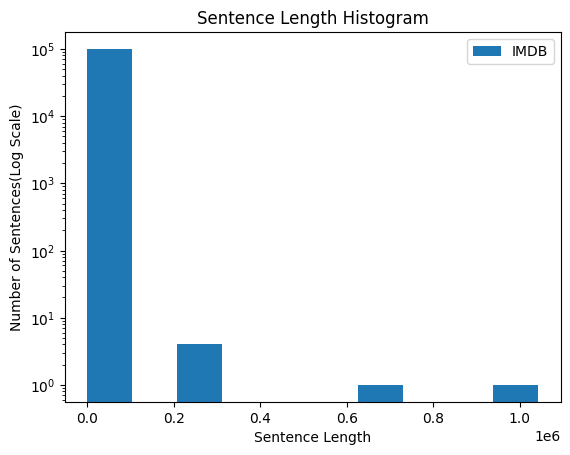

In [ ]:
# 인코딩된 길이 시각화
plt.hist(x=list(map(len, dataset)), label="IMDB")
plt.title("Sentence Length Histogram")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Sentences(Log Scale)")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
sequence_length = 300
over_cnt = len([i for i in dataset if len(i) > sequence_length])
print(f"길이가 {sequence_length}보다 더 긴 리뷰의 갯수: {over_cnt}")

길이가 300보다 더 긴 리뷰의 갯수: 31923


In [ ]:
max_len = max(map(len, dataset))
print(f"가장 긴 인코딩 길이: {max_len}")

가장 긴 인코딩 길이: 1042246


In [ ]:
del text_series

In [ ]:
gc.collect()

15158

In [ ]:
dataset = pad_sequences(sequences=dataset, maxlen=sequence_length + 1, padding="post", truncating="post")

# 모델

## 데이터셋 생성

In [ ]:
rate = 0.95
batch_size = 64

train_dataset, valid_dataset = make_dataset(data=dataset, rate=rate, batch_size=batch_size)

In [ ]:
for s, t in train_dataset.take(1):
    print(s)
    print(t)

tf.Tensor(
[[19955  1510  1884 ...   408   267   357]
 [ 1950   478 11077 ...   384  1006   293]
 [19955   916   896 ...  1585   292   267]
 ...
 [19976 12794   548 ...   640   448 19977]
 [19955   532  3989 ...   575 11793  1470]
 [ 1298  3184   346 ...     0     0     0]], shape=(64, 300), dtype=int32)
tf.Tensor(
[[ 1510  1884   264 ...   267   357  2581]
 [  478 11077 19977 ...  1006   293   267]
 [  916   896   469 ...   292   267   364]
 ...
 [12794   548   982 ...   448 19977 19957]
 [  532  3989   324 ... 11793  1470   293]
 [ 3184   346 10313 ...     0     0     0]], shape=(64, 300), dtype=int32)


## 모델 아키텍처

In [ ]:
num_layers = 4
embed_dim = 256
dense_dim = 1024
num_heads = 16
dropout_rate = 0.15

model = GPT(num_layers=num_layers, sequence_length=sequence_length,
                  input_dim=vocab_size, embed_dim=embed_dim,
                 dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)

## 모델 훈련

### 컴파일 옵션

In [ ]:
learning_rate = CustomSchedule(embed_dim=embed_dim)
optimizer = tf.keras.optimizers.Nadam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

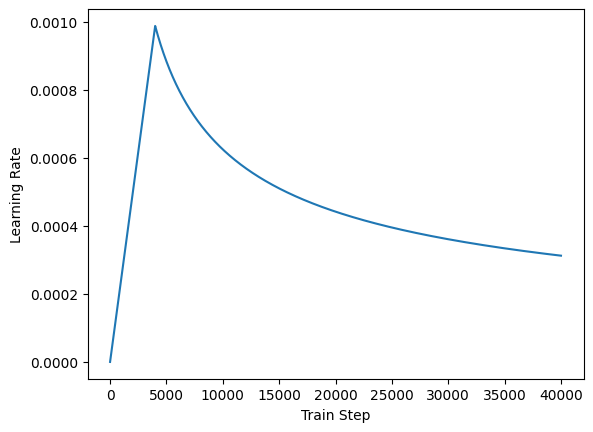

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

### 훈련

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                patience=5, restore_best_weights=True),
                  TensorBoard(log_dir="/full_path_to_your_log_dir")
                  ]

history = model.fit(train_dataset, epochs=100, shuffle=True, validation_data=valid_dataset, callbacks=callbacks_list)

Epoch 1/100
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 708s 453ms/step - loss: 7.6068 - masked_accuracy: 0.0880 - val_loss: 5.1093 - val_masked_accuracy: 0.1944
Epoch 2/100
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 646s 435ms/step - loss: 4.8919 - masked_accuracy: 0.2088 - val_loss: 4.5742 - val_masked_accuracy: 0.2326
Epoch 3/100
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 645s 435ms/step - loss: 4.4781 - masked_accuracy: 0.2400 - val_loss: 4.3962 - val_masked_accuracy: 0.2505
Epoch 4/100
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 645s 434ms/step - loss: 4.2750 - masked_accuracy: 0.2585 - val_loss: 4.2848 - val_masked_accuracy: 0.2631
Epoch 5/100
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 645s 435ms/step - loss: 4.1189 - masked_accuracy: 0.2741 - val_loss: 4.2369 - val_masked_accuracy: 0.2694
Epoch 6/100
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 645s 435ms/step - loss: 4.0174 - masked_accuracy: 0.2845 - val_loss: 4.2217 - val_masked_accuracy: 0.2725
Epoch 7/100
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 645s 435ms/step - loss: 3.9434 - masked_accuracy: 0.2920 - val_

In [ ]:
model.summary()

Model: "gpt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Decoder_PositionalEmbedding          │ ?                           │       5,196,800 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer (DecoderLayer)         │ ?                           │       4,733,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_1 (DecoderLayer)       │ ?                           │       4,733,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_2 (DecoderLayer)       │ ?                           │       4,733,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_3 (DecoderLayer)       │ ?                           │       4,733,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 300, 20000)          │       5,140,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,811,682 (334.97 MB)

 Trainable params: 29,270,560 (111.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,541,122 (223.32 MB)

# 텍스트 생성

In [ ]:
text_gen = TextGenerator(tokenizer=sp, target_length=50, model=model)

In [ ]:
k = 3
text_gen(sentence="I can't believe it!", k=k)

"i can not believe it! the story is not very good, but the characters are so bad that you feel the needy, the story is so bad that i can not believe i actually sat down to watch the movie! the acting is so bad that it's laughable!"